In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm

# Improving Olist's Estimated Delivery Time (ETA)

Estimated Time Arrival (ETA) is a key component of modern e-commerce services. It allows to manage customer expectations by displaying a predicted date for customer delivery.

In this challenge we will build a predictive model to improve the Olist ETA prediction of orders `wait_time`, and compare it with Olist's `expected_wait_time`

## Load and check `orders` dataset

In [2]:
# Load all orders from our training_data
from olist.order import Order

In [13]:
# import orders from tarining set. Include distance_seller_customer
orders = Order().get_training_data(with_distance_seller_customer=True)
orders.head()

,order_id,wait_time,expected_wait_time,delay_vs_expected,order_status,dim_is_five_star,dim_is_one_star,review_score,number_of_products,number_of_sellers,price,freight_value,distance_seller_customer
0,e481f51cbdc54678b7cc49136f2d6af7,8.0,15,0.0,delivered,0,0,4,1,1,29.99,8.72,18.063837
1,53cdb2fc8bc7dce0b6741e2150273451,13.0,19,0.0,delivered,0,0,4,1,1,118.70,22.76,856.292580
2,47770eb9100c2d0c44946d9cf07ec65d,9.0,26,0.0,delivered,1,0,5,1,1,159.90,19.22,514.130333
3,949d5b44dbf5de918fe9c16f97b45f8a,13.0,26,0.0,delivered,1,0,5,1,1,45.00,27.20,1822.800366
4,ad21c59c0840e6cb83a9ceb5573f8159,2.0,12,0.0,delivered,1,0,5,1,1,19.90,8.72,30.174037


## Baseline Model - Olist’s current ETA model

❓ What's the baseline we want to optimize?

The delta between Olist' `expected_wait_time` and the real `wait_time`

Plot their respective histograms, median difference and RMSE

<AxesSubplot:xlabel='expected_wait_time', ylabel='Count'>

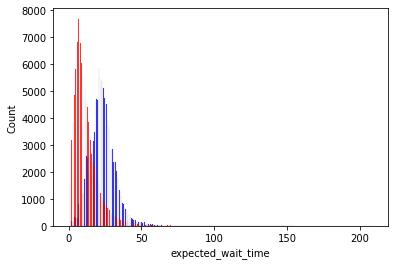

In [8]:
# Plot distributions of expected_wait_time and real wait_time
#fig,axes=plt.subplots(1,2)
sns.histplot(orders['expected_wait_time'],color='blue')#,ax=axes[0])
sns.histplot(orders['wait_time'],color='red')#,ax=axes[1])

In [9]:
# Compute medians
print(orders['expected_wait_time'].median(),orders['wait_time'].median())

23.0 10.0


In [28]:
# Compute baseline RMSEs (i.e 𝛔(error_from_olist))
RMSE=(orders['expected_wait_time']-orders['wait_time'])**2
np.sqrt(RMSE.mean())

15.211074020488258

## OLS multivariate model

We will create an OLS model using the `statsmodel.api.OLS` method (not the `statsmodel.formula.api.ols`) this time.

### Prepare dataset of features X

In [15]:
orders.corr()['wait_time']

wait_time                   1.000000
expected_wait_time          0.382769
delay_vs_expected           0.705804
dim_is_five_star           -0.235160
dim_is_one_star             0.306295
review_score               -0.334931
number_of_products         -0.019302
number_of_sellers          -0.040832
price                       0.055787
freight_value               0.166976
distance_seller_customer    0.392985
Name: wait_time, dtype: float64

In [16]:
# Create target variable y (Series) and feature X (DataFrame) without data leaks!
y=orders['wait_time']
X=orders[['freight_value','distance_seller_customer']]

In [17]:
# standardize (z-normalize) each feature of X to compare coefficients
X=X.apply(lambda x: (x-x.mean())/x.std(),axis=0)

In [ ]:
# Check how different is it from the "formula" in statsmodel
import patsy
patsy.dmatrix('price + distance_seller_customer', orders)

In [20]:
# Always add a constant "intercept" to your model
X['intercept']=1

### Run OLS with statsmodels and print summary

In [21]:
model = sm.OLS(y,X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              wait_time   R-squared:                       0.157
Model:                            OLS   Adj. R-squared:                  0.157
Method:                 Least Squares   F-statistic:                     8957.
Date:                Wed, 21 Jul 2021   Prob (F-statistic):               0.00
Time:                        17:28:02   Log-Likelihood:            -3.4651e+05
No. Observations:               96525   AIC:                         6.930e+05
Df Residuals:                   96522   BIC:                         6.931e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
freight_value                0.4617      0.030     15.534      0.000       0.403       0.520
distance_seller_customer     3.6064      0.030    121.342      0.000       3.548       3.665
intercept                   12.0907      0.028    428.482      0.000      12.035      12.146
==============================================================================
Omnibus:                    92915.564   Durbin-Watson:                   1.989
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         10571428.602
Skew:                           4.387   Prob(JB):                         0.00
Kurtosis:                      53.512   Cond. No.                         1.38
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Check model performance

### Goodness of fit

<AxesSubplot:xlabel='wait_time', ylabel='Count'>

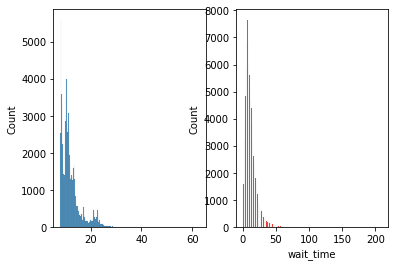

In [27]:
# Check prediction distributions
fig,axes=plt.subplots(1,2)
sns.histplot(model.predict(),ax=axes[0])
sns.histplot(y,color='red',ax=axes[1])
# identique --> sns.histplot(model.fittedvalues)
# prediction nouvelles données --> sns.histplot(model.predict(X_2))

In [24]:
# Compute RMSE (i.e 𝛔(residuals))
RMSE=model.resid**2
np.sqrt(RMSE.mean())

8.766656616853831

In [30]:
model.params

freight_value                0.461673
distance_seller_customer     3.606354
intercept                   12.090743
dtype: float64

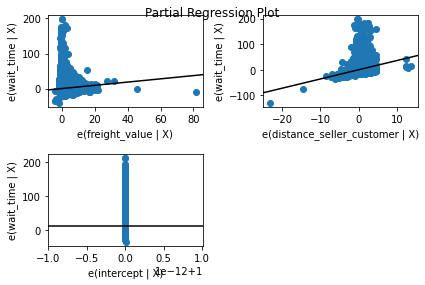

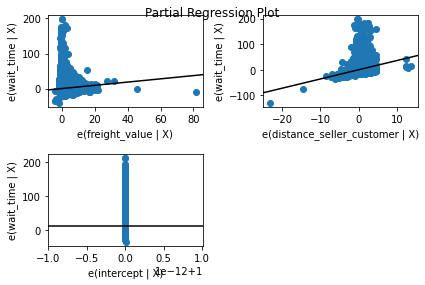

In [31]:
# Visualize partial correlations with "sm.graphics.plot_partregress_grid"
sm.graphics.plot_partregress_grid(model)

**How to read these graphs (partial reg of `wait_time` against `distance` for instance)**

- Each point is an order in our dataset


- Y value is the residual of the `wait_time`, by using all features except `distance`

    - These residuals contain the remaining information about `wait_time` that couldn't be explained without `distance`


- X value is the residual of predicting `distance` by using all other features (price, freight_value, etc...)
    - These residuals contain the new information that `distance` brings to the table, which is not already explained by the other features in the model.



### Inferential conditions

❓ Check you residuals. Are they normally distributed?

<AxesSubplot:ylabel='Count'>

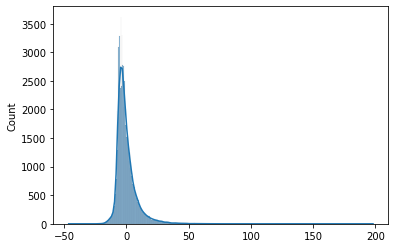

In [33]:
sns.histplot(model.resid,kde=True)

<AxesSubplot:xlabel='distance_seller_customer'>

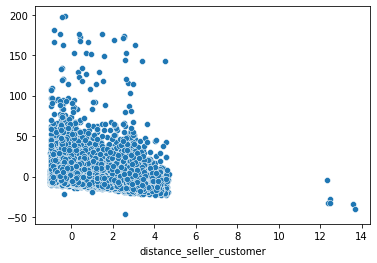

In [34]:
sns.scatterplot(x=X['distance_seller_customer'],y=model.resid)

❓A more precise way to visualize normality is the [QQplot](https://www.statsmodels.org/stable/generated/statsmodels.graphics.gofplots.qqplot.html). 
Plot the qqplot of your residual below, and make sure to understand the link with the histogram above.

Interpreting QQplots ([source](https://stats.stackexchange.com/questions/101274/how-to-interpret-a-qq-plot))
- dots are arranged on `y-axis` in ascending order of values (y-axis = residual values)
- dots are spaced on `x-axis` proportionally to a "normal distribution"

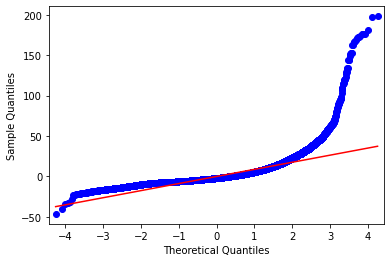

In [36]:
# Run cell below
sm.qqplot(model.resid, line='s');

<AxesSubplot:ylabel='Count'>

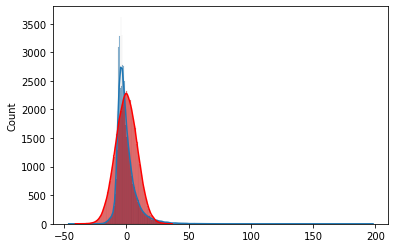

In [42]:
nb_points=len(model.resid)
moy=model.resid.mean()
ecart=model.resid.std()
norm_1 = [stats.norm.rvs(moy,ecart) for x in range(nb_points)]

sns.histplot(model.resid,kde=True)
sns.histplot(norm_1,kde=True,color='red')

#### QQ plot examples

Run the cells below to understand how QQ plots are made

In [37]:
from scipy import stats 
stats.norm.rvs(0,1)

0.3130150935782517

/Users/nizar/.pyenv/versions/lewagon/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/nizar/.pyenv/versions/lewagon/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(-4.879417289952466, 10.0)

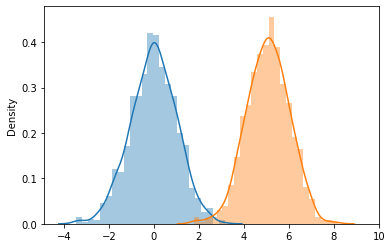

In [38]:
# lets check QQ plots with our own distributions
from scipy import stats

norm_1 = [stats.norm.rvs(0,1) for x in range(1000)]
norm_2 = [stats.norm.rvs(5,1) for x in range(1000)]

sns.distplot(norm_1)
sns.distplot(norm_2)
plt.xlim(right=10)

In [ ]:
sm.qqplot(np.asarray(norm_1), line='s');

In [ ]:
bimodal = norm_1 + norm_2
sns.distplot(bimodal)
plt.xlim(right=10)

In [ ]:
sm.qqplot(np.asarray(bimodal), line='s');

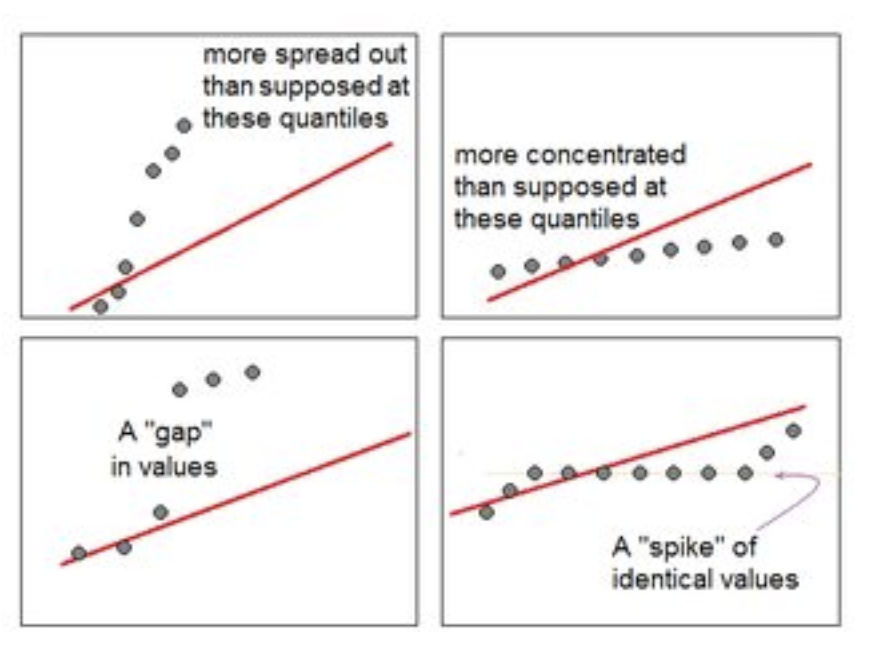

#### Finally, check your residuals vs. fitted to see if we can detect any non-random pattern

## Add more Features? (Optional)

Here we can add additional features from the product details (size, category etc..)

### Add product details associated with each order (sum of product sizes, sum of weights etc...)

In [ ]:
from olist.data import Olist
data = Olist().get_data()
products = data['products']
order_items = data['order_items']

In [ ]:
order_items_products = (
    order_items.groupby(["order_id", "product_id"], as_index=False)
    .agg({"order_item_id": "count"})
    .rename(columns={"order_item_id": "order_item_count"})
    .merge(products.drop(["product_category_name"], axis=1), on="product_id")
)
order_items_products

In [ ]:
order_items_features = order_items_products.groupby("order_id", as_index=False).agg(
    {
        "product_weight_g": "sum",
        "product_length_cm": "max",
        "product_height_cm": "max",
        "product_width_cm": "max",
    }).rename(columns={
        "product_weight_g": "product_weight_g_sum",
        "product_length_cm": "product_length_cm_max",
        "product_height_cm": "product_height_cm_max",
        "product_width_cm": "product_width_cm_max",
    })
order_items_features

In [ ]:
orders_with_details = orders.merge(order_items_features, on="order_id", how="left").dropna()

In [ ]:
X2 = orders_with_details[[
        "number_of_products",
        "number_of_sellers",
        "price",
        "freight_value",
        "distance_seller_customer",
        "product_weight_g_sum",
        "product_length_cm_max",
        "product_height_cm_max",
        "product_width_cm_max"]].copy()
y2 = orders_with_details["wait_time"].copy()

In [ ]:
# standardize (z-normalize) each features of X to compare coefficients
for f in X2.columns:
    mu = X2[f].mean()
    sigma = X2[f].std()
    X2[f] = X2[f].map(lambda x: (x - mu) / sigma)

In [ ]:
X2['constant'] = 1

In [ ]:
model2 = sm.OLS(y2, X2).fit()

In [ ]:
model2.summary()